In [1]:
#%pip install nltk

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# Начальные параметры для модели
import re
from scipy import stats
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import string
#import spacy

import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import time
nltk.downloader.download('vader_lexicon')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\79262\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\79262\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
RANDOM_SEED = 42 #фиксируем SEED

In [4]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

"pip" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


## Данные из соревнования

### Первоначальная версия датасета содержит 17 полей со следующей информацией:

- hotel_address — адрес отеля;
- review_date — дата, когда рецензент разместил соответствующий отзыв;
- average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
- hotel_name — название отеля;
- reviewer_nationality — страна рецензента;
- negative_review — отрицательный отзыв, который рецензент дал отелю;
- review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
- positive_review — положительный отзыв, который рецензент дал отелю;
- review_total_positive_word_counts — общее количество слов в положительном отзыве.
- reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
- total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
- total_number_of_reviews — общее количество действительных отзывов об отеле;
- tags — теги, которые рецензент дал отелю;
- days_since_review — количество дней между датой проверки и датой очистки;
- additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
- lat — географическая широта отеля;
- lng — географическая долгота отеля.
- sample
- reviewer_score - в конце таблицы он меняет значение, которое становится не равным нулю

In [5]:
test_data = pd.read_csv('hotels_test.csv')
train_data = pd.read_csv('hotels_train.csv')


### Объединим train и test в один датасет

In [6]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
train_data['sample'] = 1 # помечаем train
test_data['sample'] = 0 # помечаем test
test_data['reviewer_score'] = 0 
# в test у нас нет значения reviewer_score, мы его должны предсказать, по этому заполняем нулями

data = test_data.append(train_data, sort=False).reset_index(drop=True)

C:\Users\79262\AppData\Local\Temp\ipykernel_192\2780954104.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = test_data.append(train_data, sort=False).reset_index(drop=True)


### Анализируем данные

In [7]:
print(data.shape)
data.tail(3)

(515738, 18)


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
515735,29 31 Gower Street Camden London WC1E 6HG Unit...,457,2/7/2016,6.8,Bloomsbury Palace Hotel,Netherlands,room is really small but guess is normal in L...,12,2751,great location simple check in out nice shower,9,21,"[' Business trip ', ' Solo traveler ', ' Singl...",543 day,51.520795,-0.131084,1,8.3
515736,31 Great Cumberland Place Westminster Borough ...,365,5/21/2017,8.1,The Marble Arch London,United Arab Emirates,No Negative,0,1567,Location and very comfy bed,6,28,"[' Leisure trip ', ' Solo traveler ', ' Deluxe...",74 days,51.515125,-0.160066,1,9.2
515737,25 Courtfield Gardens Kensington and Chelsea L...,222,8/5/2016,9.0,The Nadler Kensington,Australia,Patio outside could have been cleaned of alga...,20,1209,Beds comfortable Pillows also good Homely fee...,20,2,"[' Leisure trip ', ' Couple ', ' Bunk Bed Room...",363 day,51.493109,-0.190208,1,8.8


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

- в признаках lat и lng имеются пропуски. т.е. не все геоданные отелей указаны.
- числовые данные в:
 - additional_number_of_scoring
 - average_score
 - review_total_negative_word_counts
 - total_number_of_reviews
 - review_total_positive_word_counts
 - total_number_of_reviews_reviewer_has_given
 - reviewer_score
 - lat
 - Ing
- признак даты в столбце review_date
- с остальными надо разбираться внимательнее

### Воспользуемся бонусом "EDA одной строкой кода")

In [9]:
# pip install pandas-profiling

In [10]:
#from pandas_profiling import ProfileReport
#profile = ProfileReport(data, title="Booking Pandas Profiling Report")
#profile

Анализ profile даёт нам:
- статистика датасета:
 - 18 признаков
 - 515738 строк(значений)
 - 6536 отсутствующих значений
- типы переменных:
 - 9 цифровых
 - 9 категорий
- предупреждение о:
 - 336 дубликатов строк(значений)
 - review_total_negative_word_counts имеют 127890 (24.8%) нулевых значений
 - review_total_positive_word_counts имеют 35946 (7.0%) нулевых значений
 - список признаков с высокой корреляцией
 - перечень признаков с большим количеством элементов
 #### предварительный вывод:
1. Анализ дубликатов строк показывает, что данные дублируются два раза в 100% случаях, т.е. часть таблицы загружена дважды. (перепроверить, пометить)
2. 6536 отсутствующих значений - из .info ясно, что это в признаках lat и lng имеются пропуски именно в этом количестве. Надо извлечь адрес отеля и по адресу установить координаты. (правда, не знаю как?) 
3. Нулевые значения в количестве слов в отзывах - думаю поставить наименьшее значение в признаке, т.к. негативный или позитивный отзыв всё-таки установлен, но клиент не приложил усилие по написанию слов, что, по-моему, является минимально влияющим аспектом.
4. А вот уровень эмоциональности отзыва должна сильно влиять на рейтинг отеля. Пользуясь подсказкой нашего ментора Сергея Добдина думаю воспользоваться библиотекой для обработки текстов для классификации nltk.
5. Список с высокой корреляцией отработаю.

## Разбор признаков

### 1.Oтметим дублированные строки

In [ ]:
data['duplicat'] = data.duplicated()
#def dupl(arg):
#    if False in arg:
#        return 0
#    elif True:
#        return 1
#data['duplicated'] = data['duplicat'].apply(dupl)
#data = data.drop(['duplicat'], axis=1)
data.head()
#  НЕ РАБОТАЕТ

In [51]:
print(data[data['duplicat'] == True].shape[0])

336


In [12]:
data['duplicat'].describe()

count     515738
unique         2
top        False
freq      515402
Name: duplicat, dtype: object

In [13]:
# Здесь видны дубликаты
sorted = data.sort_values(by='duplicat')
sorted.tail() 

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,duplicat
514376,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,8/25/2015,7.9,H tel Concorde Montparnasse,France,Rooms not very noise insulated within the bui...,9,2515,No Positive,0,18,"[' Leisure trip ', ' Couple ', ' Superior Doub...",709 day,48.838108,2.318669,1,8.3,True
423537,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,8/18/2015,7.9,H tel Concorde Montparnasse,United Kingdom,Very poor service wifi almost none exists bre...,14,2515,Location is not bad,6,2,"[' Leisure trip ', ' Group ', ' Classic Twin R...",716 day,48.838108,2.318669,1,3.3,True
335184,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,3/1/2016,7.9,H tel Concorde Montparnasse,Turkey,Small room size limited sunlight,7,2515,Perfect location Friendly staff,6,4,"[' Leisure trip ', ' Couple ', ' Classic Doubl...",520 day,48.838108,2.318669,1,8.8,True
505307,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,10/1/2015,7.9,H tel Concorde Montparnasse,United Kingdom,No kettle in our room,6,2515,The location,3,1,"[' Leisure trip ', ' Couple ', ' Superior Doub...",672 day,48.838108,2.318669,1,7.0,True
429457,9 Rue Sainte Beuve 6th arr 75006 Paris France,22,4/6/2017,8.9,Hotel Le Sainte Beuve,United Kingdom,I asked if i could have a coffee the morning ...,47,143,No Positive,0,10,"[' Leisure trip ', ' Couple ', ' Superior Room...",119 day,48.843900,2.329486,1,5.0,True


### 2. Географические координаты
Пропущены данные в столбцаx lat и lng. Это категориальные признаки. Не имеет смысла заполнять их какими-то значениями, так как это географическое положение. Заполним пропущенные значения нулями.

In [14]:
data['lat'] = data['lat'].fillna(0, inplace=True)
data['lng'] = data['lng'].fillna(0, inplace=True)

Есть ли среди названий отелей одинаковые, но при этом находящиеся в разных городах? Проверим.

In [15]:
name_address = data.pivot_table(
    values = 'hotel_address',
    index = 'hotel_name',
    aggfunc = 'nunique'
)
name_address.head()

,hotel_address
hotel_name,
11 Cadogan Gardens,1
1K Hotel,1
25hours Hotel beim MuseumsQuartier,1
41,1
45 Park Lane Dorchester Collection,1


In [16]:
dupl = name_address[name_address['hotel_address'] > 1]
dupl

,hotel_address
hotel_name,
Hotel Regina,3


Да, Hotel Regina популярен в трёх местах.
Надо идентифицировать отель Hotel Regina по городам.

In [17]:
# Cоздадим список, в котором будет храниться название отеля, имеющее несколько адресов.
dupl_list = dupl[dupl['hotel_address'] > 1].index.to_list()
dupl_list

['Hotel Regina']

In [18]:
data['hotel_name'] = data.apply(lambda x: (x['hotel_name'] + ' in ' + x['hotel_address'].split()[-1])
    if (x['hotel_name'] in dupl_list) else x['hotel_name'], axis=1)
data['hotel_name'].nunique()

1494

получили 1494 уникальных значений отелей

### Преобразуем адрес отеля

посмотрим как выглядит запись адреса в DF

In [19]:
data['hotel_address'].head()

0                   Via Senigallia 6 20161 Milan Italy
1    Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...
2          Mallorca 251 Eixample 08008 Barcelona Spain
3    Piazza Della Repubblica 17 Central Station 201...
4    Singel 303 309 Amsterdam City Center 1012 WJ A...
Name: hotel_address, dtype: object

In [20]:
# извлекаем признак страны из hotel_address
data['hotel_country'] = data['hotel_address'].apply(lambda x: x.split(' ')[-1])
data['hotel_country'] = data['hotel_country'].apply(lambda x: 'United Kingdom' if x == 'Kingdom' else x)
display(data['hotel_country'].value_counts())


United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: hotel_country, dtype: int64

In [21]:
# извлекаем признак города из hotel_address 
data['hotel_city'] = data['hotel_address'].apply(lambda x: x.split(' ')[-2])
data['hotel_city'] = data['hotel_city'].apply(lambda x: 'London' if x == 'United' else x)
display(data['hotel_city'].value_counts())

London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: hotel_city, dtype: int64

Получается у нас отели из шести городов шести стран. Закодируем страну. 

In [22]:
data['hotel_country'] = data['hotel_country'].astype('category')
data['hotel_country_code'] = data['hotel_country'].cat.codes

Близкое расположение отеля к местным достопримечательностям наверняка улучшит отзыв об отеле. Но определить расположение достопримечательности в центре города было бы не правильно. (я только что приехал из Севастополя...) Плюс основная часть туристов посещала гостиниу в течении одной ночи, что свидетельствует скорее о командировке и достопримечательности в этом случае не принимаются в расчет.
Так же у нас есть адрес отеля и этого уже достаточно.
Поэтому географические координаты удаляем.

In [23]:
data = data.drop(['lat', 'lng'], axis=1)
data.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,sample,reviewer_score,duplicat,hotel_country,hotel_city,hotel_country_code
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,0,0.0,False,Italy,Milan,2
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,0,0.0,False,Netherlands,Amsterdam,3
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,0,0.0,False,Spain,Barcelona,4
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,0,0.0,False,Italy,Milan,2
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,0,0.0,False,Netherlands,Amsterdam,3


In [24]:
# после извлечения полезных данных из hotel_address, его можно удалить
data = data.drop(['hotel_address'], axis=1)
data.head(3)

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,sample,reviewer_score,duplicat,hotel_country,hotel_city,hotel_country_code
0,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,0,0.0,False,Italy,Milan,2
1,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,0,0.0,False,Netherlands,Amsterdam,3
2,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,0,0.0,False,Spain,Barcelona,4


In [25]:
# добавляем население города
сity_population = {
    'Paris': 2139907, 'London': 9002488, 'Milan': 1374582,
    'Vienna': 1951354, 'Barcelona': 1636732, 'Amsterdam': 905234
}

data['сity_population'] = data['hotel_city'].map(сity_population)

### 3. Слова в отзывах (тэги)
проанализируем:
 - кол-во уникальных тэгов
 - популярные тэги
 - количество ночей 
 - зависимость длительности проживания от количества оценок

In [26]:
def count_tags(tags):
    express = re.findall("'[^\'](.+?)[^\']'", tags)
    return express

print('Уникальных тэгов: ', data['tags'].apply(count_tags).explode().nunique())

Уникальных тэгов:  2428


In [27]:
# напишем функцию для создания словаря с подсчетом тегов
unique_dic = {}
def make_unique_dic(x):
    x = x[3:-3].split(" ', ' ")
    for elem in x:
        if elem in unique_dic:
            unique_dic[elem] = unique_dic[elem] + 1
        else:
            unique_dic[elem] = 1
    return x

data['tags'].apply(make_unique_dic)

# получим датафрейм со всеми тегами и их частотой встречаемости
unique_tags = pd.DataFrame(unique_dic, index=['count']).transpose()
display(unique_tags)

,count
Leisure trip,417778
Couple,252294
Double Room,35207
Stayed 2 nights,133937
Group,65392
...,...
Executive Suite with River View,1
Family Room 6 Adults,1
Two Adjoining Rooms with Dock View Upper Deck,1
Westminster Suite with King Bed,1


In [28]:
# Введём новый признак count_nights (количество ночей)
def count_nights(tags):
    express = re.findall(r'Stayed\s([0-9]+)\snight', tags)
    return express

data['count_nights'] = data['tags'].apply(count_nights)

def convert(feature):
    for elem, num in enumerate(feature):
        return np.float64(num)
    
data['count_nights'] = data['count_nights'].apply(convert).convert_dtypes().fillna(1)

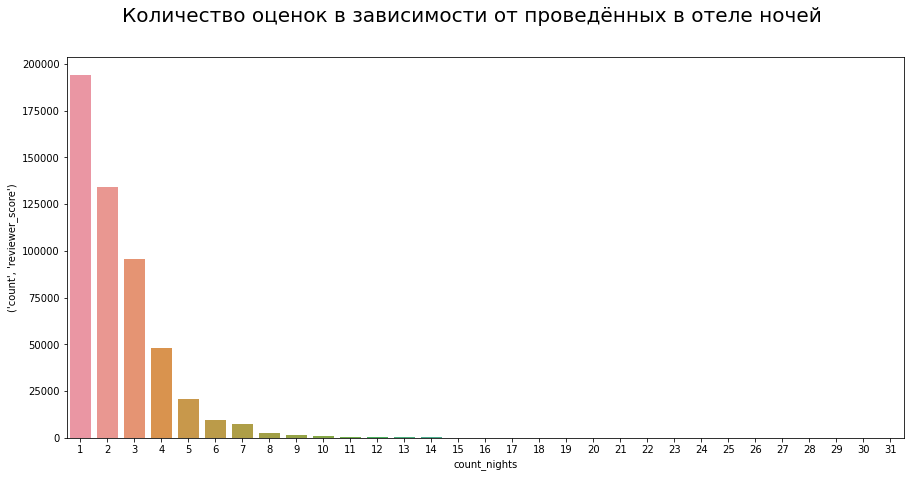

In [29]:
pivot_nights = pd.pivot_table(
    data=data,
    index='count_nights', 
    values='reviewer_score', 
    aggfunc=['count', 'mean'])
fig1, ax1 = plt.subplots(figsize=(15, 7))
plt.suptitle(
    'Количество оценок в зависимости от проведённых в отеле ночей', size=20)
sns.barplot(x=pivot_nights.index, y=pivot_nights[('count', 'reviewer_score')]);

### 4. Уровень эмоциональности
целочисленные значения, которые нам подходят:
- Общее количество отзывов total_number_of_reviews_reviewer_has_given
- Признак review_total_negative_words_count и review_total_positive_word_counts
- Признак total_negative_words_count и total_positive_words_count

Признак days_since_review представлен строкой - преобразуем его и получим оттуда число.

In [30]:
def count_days(feature):
    count = re.findall(r'\d+', feature)
    return count
    
data['days_since_review'] = data['days_since_review'].apply(count_days)
data['days_since_review'] = data['days_since_review'].apply(convert).convert_dtypes()
# Приведём review_date к типу datetime64:
data['review_date'] = pd.to_datetime(data['review_date'])

Проверим, влияет ли сезонность на количество оценок

In [31]:
data['review_month'] = data['review_date'].dt.month
score_month = data[data['sample']==1].pivot_table(
values='reviewer_score',
index='review_month',
aggfunc='mean')
score_month

,reviewer_score
review_month,
1,8.482245
2,8.534773
3,8.481505
4,8.432322
5,8.385711
6,8.387010
7,8.339102
8,8.412986
9,8.293349


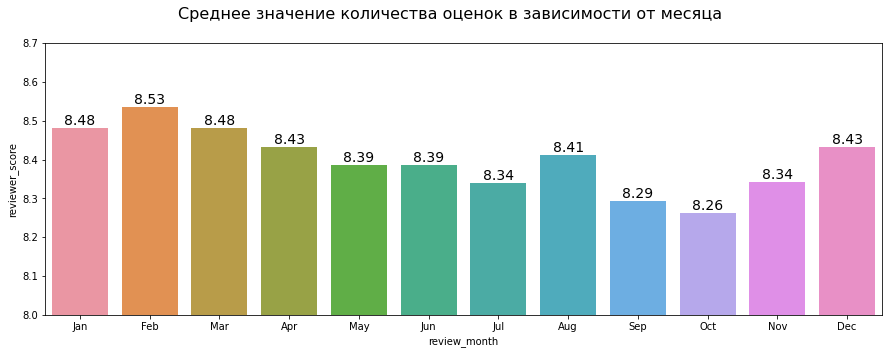

In [32]:
fig2, ax2 = plt.subplots(figsize=(15, 5))
plt.suptitle('Среднее значение количества оценок в зависимости от месяца', size=16)
bar_month = sns.barplot(
    x=score_month.index, 
    y=score_month['reviewer_score'])
ax2.set_xticklabels([
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

for p in bar_month.patches:
    bar_month.annotate(
        '{:.2f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
    ha='center', va='bottom', fontsize=14)

plt.ylim(8, 8.7);

Есть просадка показателей в летний период. Предполагаю в процентном содержании становится больше отдыхающих, по сравнению с командировочными...)

### Пробуем библиотеку для обработки текстов для классификации nltk, которая различает эмоциональную тональность отзыва

In [33]:
# Создаём объекты SentimentIntensityAnalyzer
positive = SentimentIntensityAnalyzer()
negative = SentimentIntensityAnalyzer()

# посмотрим как изменится характеристика слова 'nothing':
example = 'nothing'
print(f'Словарь оценок слова "{example}" до преобразований:')
print(negative.polarity_scores(example), '\n')

# добавим контекст:
negative_words = {'small': -1, 'nothing': 10}
positive_words = {'nothing': -10, 'everything': 10}
negative.lexicon.update(negative_words)
positive.lexicon.update(positive_words)

print(f' - после преобразований (для негативного контекста):')
print(negative.polarity_scores(example))
print(f' - после преобразований (для позитивного контекста):')
print(positive.polarity_scores(example))

# фразы "No Negative" тонально будет нести негативную окраску:
example = 'No Negative'
print(f'\nСловарь оценок фразы "{example}":')
print(negative.polarity_scores(example))
example = 'Positive'
print(f'Словарь оценок фразы "{example}":')
print(negative.polarity_scores(example))

# меняем метки отсутствия частей отзыва:
data['negative_review_temp'] = data['negative_review'].apply(lambda x: x.replace('No Negative', 'Positive'))
data['positive_review_temp'] = data['positive_review'].apply(lambda x: x.replace('No Positive', 'Negative'))

Словарь оценок слова "nothing" до преобразований:
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0} 

 - после преобразований (для негативного контекста):
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.9325}
 - после преобразований (для позитивного контекста):
{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.9325}

Словарь оценок фразы "No Negative":
{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.7096}
Словарь оценок фразы "Positive":
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5574}


In [34]:
%%time

data['negative_review_sentiments'] = data['negative_review_temp'].apply(lambda x: negative.polarity_scores(x))

data['positive_review_sentiments'] = data['positive_review_temp'].apply(lambda x: positive.polarity_scores(x))

# формируем новые признаки:
data['neg_review_sentiments_neg'] = data['negative_review_sentiments'].apply(lambda x: x['neg'])
data['neg_review_sentiments_neu'] = data['negative_review_sentiments'].apply(lambda x: x['neu'])
data['neg_review_sentiments_pos'] = data['negative_review_sentiments'].apply(lambda x: x['pos'])
data['neg_review_sentiments_compound'] = data['negative_review_sentiments'].apply(lambda x: x['compound'])

data['pos_review_sentiments_neg'] = data['positive_review_sentiments'].apply(lambda x: x['neg'])
data['pos_review_sentiments_neu'] = data['positive_review_sentiments'].apply(lambda x: x['neu'])
data['pos_review_sentiments_pos'] = data['positive_review_sentiments'].apply(lambda x: x['pos'])
data['pos_review_sentiments_compound'] = data['positive_review_sentiments'].apply(lambda x: x['compound'])

CPU times: total: 4min 23s
Wall time: 4min 35s


In [95]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 21 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   review_total_positive_word_counts           515738 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 5   days_since_review                           515738 non-null  Int64  
 6   sample                                      515738 non-null  int64  
 7   reviewer_score                              515738 non-null  float64
 8   duplicat                                    515738 non-null  bool   
 9   hotel_country_code                          515738 non-null  int8   
 

In [96]:
cols_num = [
    'review_total_negative_word_counts',
    'review_total_positive_word_counts',
    'days_since_review',
    'total_number_of_reviews_reviewer_has_given',
    'reviewer_score',
    'сity_population',
    'neg_review_sentiments_neg',
    'neg_review_sentiments_neu',
    'neg_review_sentiments_pos',
    'neg_review_sentiments_compound',
    'pos_review_sentiments_neg',
    'pos_review_sentiments_neu',
    'pos_review_sentiments_pos',
    'pos_review_sentiments_compound'   
]

cols_cat = [
    'additional_number_of_scoring',
    'average_score',
    'total_number_of_reviews',
    'duplicat',
    'hotel_country_code',
    'count_nights',
    'review_month',
]

KeyError: "['total_number_of_reviews'] not in index"

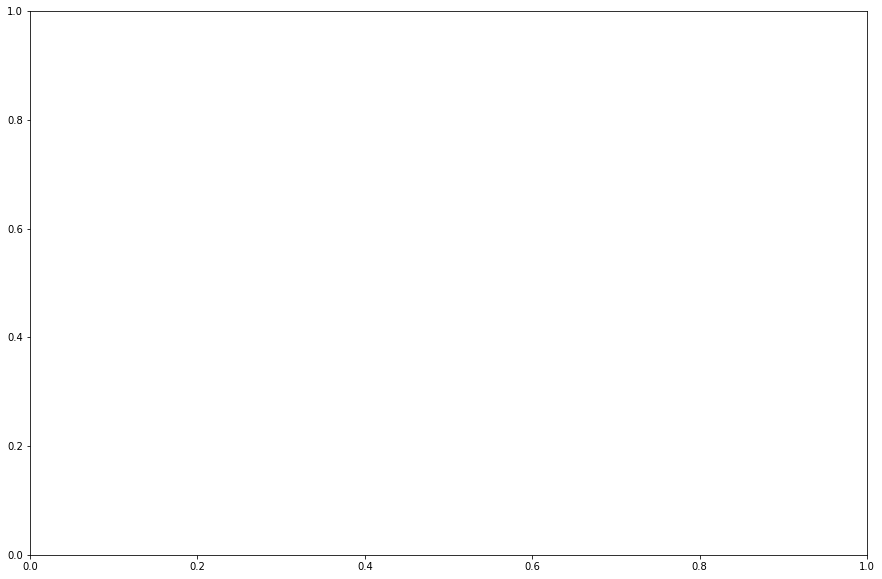

In [100]:
fig_, ax_ = plt.subplots(figsize=(15, 10))
corr = data[cols_cat].corr(method='pearson')
sns.heatmap(corr, 
            annot=True, 
            linewidths=0.1, 
            fmt='.1g')
ax_.set_title('Корреляция непрерывных признаков', fontsize=18)
plt.show()

In [90]:
del_cols = ['neg_review_sentiments_pos']

KeyError: "['total_number_of_reviews'] not in index"

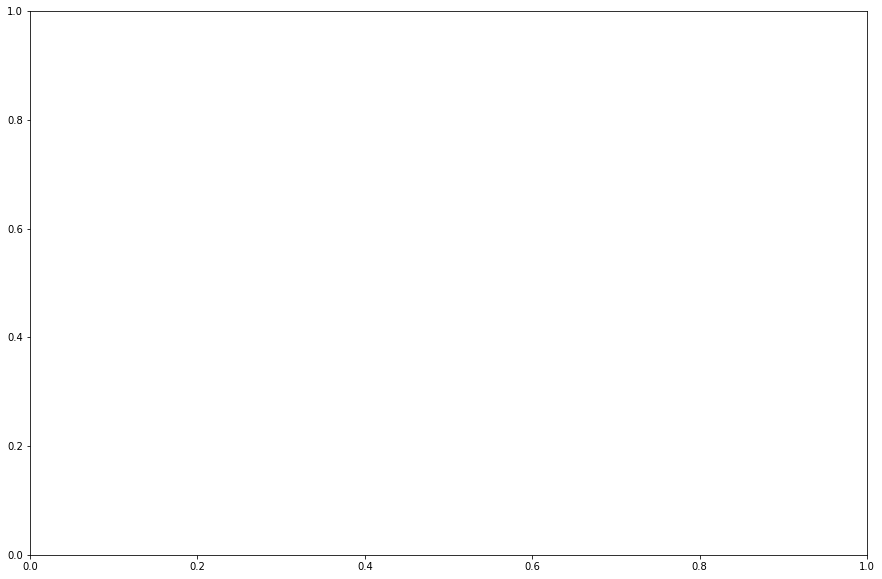

In [99]:
fig_, ax_ = plt.subplots(figsize=(15, 10))
corr = data[cols_cat].corr(method='pearson')
sns.heatmap(corr, 
            annot=True, 
            linewidths=0.1, 
            fmt='.1g')
ax_.set_title('Корреляция категориальных признаков', fontsize=18)
plt.show()

In [77]:
del_cols = ['total_number_of_reviews']

In [78]:
data.drop(del_cols, axis = 1, inplace=True)

In [80]:
print('Осталось признаков: {}'.format(data.shape[1]))

Осталось признаков: 21


In [52]:
# убираем признаки, которые ещё не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберем их и удалим
# избавимся от других нечисловых признаков: category, datetime64[ns]
cat_date_columns = [cd for cd in data.columns if ((data[cd].dtypes.name == 'category') or (data[cd].dtypes == 'datetime64[ns]'))]
data.drop(cat_date_columns, axis = 1, inplace=True)

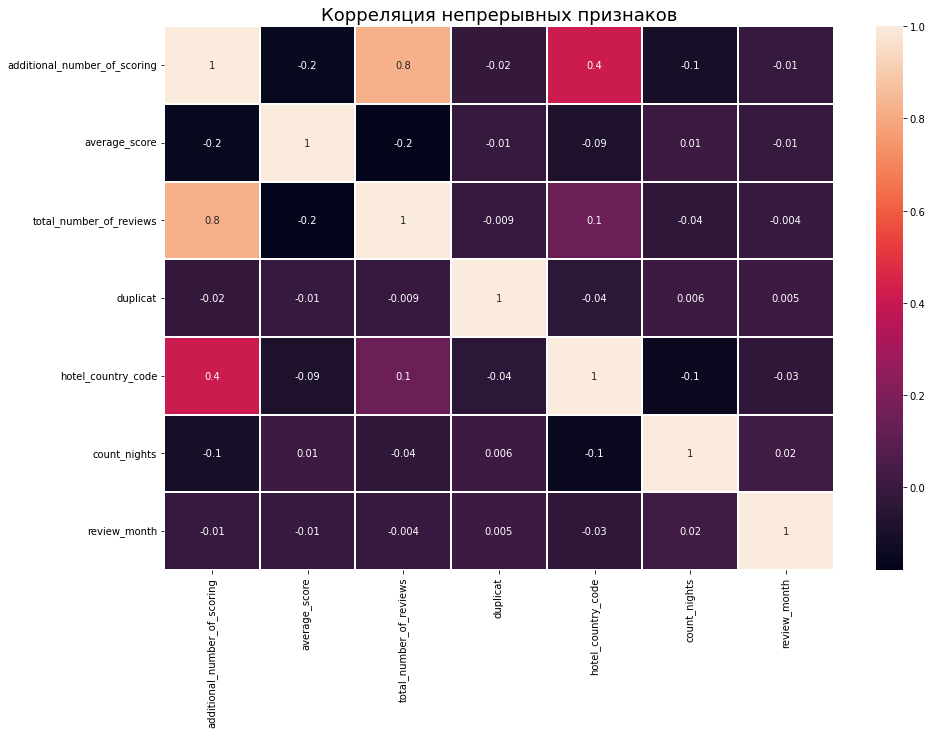

In [75]:
fig_, ax_ = plt.subplots(figsize=(15, 10))
corr = data[cols_cat].corr(method='pearson')
sns.heatmap(corr, 
            annot=True, 
            linewidths=0.1, 
            fmt='.1g')
ax_.set_title('Корреляция непрерывных признаков', fontsize=18)
plt.show()

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 24 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   additional_number_of_scoring                515738 non-null  int64         
 1   review_date                                 515738 non-null  datetime64[ns]
 2   average_score                               515738 non-null  float64       
 3   review_total_negative_word_counts           515738 non-null  int64         
 4   total_number_of_reviews                     515738 non-null  int64         
 5   review_total_positive_word_counts           515738 non-null  int64         
 6   total_number_of_reviews_reviewer_has_given  515738 non-null  int64         
 7   days_since_review                           515738 non-null  Int64         
 8   sample                                      515738 non-null  int64        

In [39]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [40]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [41]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 23), (386803, 23), (386803, 22), (309442, 22), (77361, 22))

In [42]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [43]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [44]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

TypeError: Cannot cast DatetimeArray to dtype float32

In [ ]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

In [ ]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [ ]:
test_data.sample(10)

In [ ]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [ ]:
sample_submission

In [ ]:
predict_submission = model.predict(test_data)

In [ ]:
predict_submission

In [ ]:
list(sample_submission)

In [ ]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)